In [2]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath('thinker/thinker')
if module_path not in sys.path:
    sys.path.append(module_path)

from collections import namedtuple
from matplotlib import pyplot as plt
import matplotlib.ticker as mticker
from collections import deque
import time
import numpy as np
import argparse
import torch
import torch.nn.functional as F
from thinker.env import Environment, EnvOut
from thinker.net import ActorNet, ModelNet
from thinker.buffer import ModelBuffer
from torch import nn
import thinker.util as util
import gym
import gym_csokoban

def gplot(x, ax=None, title=None):
    if ax is None: fig, ax = plt.subplots()
    if type(x) == torch.Tensor: x = x.cpu()
    if type(x) == np.ndarray: x = torch.tensor(x)       
    ax.imshow(torch.swapaxes(torch.swapaxes(x,0,2),0,1), interpolation='nearest', aspect="auto")
    if title is not None: ax.set_title(title)

In [33]:
from thinker.util import Timings
import thinker.env
from thinker.gym_add.asyn_vector_env import AsyncVectorEnv
from thinker.env import VecModelWrapper
from thinker.cenv import cVecModelWrapper

flags = util.parse([])
flags.rec_t = 5
flags.flex_t = False
flags.reward_transform = True
flags.see_encode = True

model_net = ModelNet((3,80,80), 5, flags)
_ = model_net.train(False)

def check_diff(env_out, env_out_, ind, n):
    check = ['gym_env_out', 'model_out', 'reward', 'done', 
        'episode_return', 'episode_step', 'cur_t', 'last_action',
        'max_rollout_depth']
    for c in check:
        d = torch.sum(torch.abs(getattr(env_out, c)[:,[ind]].cpu().float() - getattr(env_out_, c).cpu().float()))
        if d > 1e-3:
            if not c == 'gym_env_out':
                print(getattr(env_out, c)[0,[ind]], getattr(env_out_, c))
            else:
                gplot(getattr(env_out, 'gym_env_out')[0,ind].cpu())
                gplot(getattr(env_out_, 'gym_env_out')[0,0].cpu())
            raise Exception("Step %d [Index %d] check not passed: %s %f" %(n, ind, c, d))

torch.set_printoptions(precision=5)
env_n = 16
device = torch.device("cpu")

model_net_ = ModelNet((3,80,80), 5, flags)
model_net_.load_state_dict({k: v.cpu() for k, v in model_net.state_dict().items()})
model_net_.train(False)

flags.cwrapper = True
env = Environment(flags, env_n=env_n, device=device, time=True)
env.seed(np.arange(env_n))
model_net.to(device)
env_out, _ = env.initial(model_net)

env_ = [Environment(flags) for _ in range(env_n)]
env_out_ = []
for n in range(env_n): 
    env_[n].seed([n])
    env_out_single, _ = env_[n].initial(model_net_)
    env_out_.append(env_out_single)
    check_diff(env_out, env_out_single, n, 0)

timings = Timings()

#for n in range(env_n): gplot(env_out.gym_env_out[0,n].cpu())

for n in range(200):
    timings.reset()
    action = torch.tensor([[np.random.randint(5),
                            np.random.randint(5),
                            np.random.randint(2),
                            #np.random.randint(2)
                            ] for _ in range(env_n)])
    timings.time("s0")
    env_out, _ = env.step(action.unsqueeze(0).to(device), model_net, None)
    timings.time("s1")
    env_out_ = []
    for m in range(env_n):
        env_out_single, _ = env_[m].step(action.unsqueeze(0)[:,[m]], model_net_, None)
        env_out_.append(env_out_single)
        check_diff(env_out, env_out_single, m, n+1)
    timings.time("s2")
    
    if env_[0].env.baseline_max_q is not None:
        env_bmaxq = torch.tensor([e.env.baseline_max_q for e in env_])
        env_bmeanq = torch.tensor([e.env.baseline_mean_q for e in env_])
        diff_max_q = torch.sum(torch.abs(env.env.baseline_max_q.cpu() - env_bmaxq))
        diff_mean_q = torch.sum(torch.abs(env.env.baseline_mean_q.cpu() - env_bmeanq))
        if diff_max_q > 1e-3 or diff_mean_q > 1e-3:
            raise Exception("diff in max_q: %f mean_q %f" % (diff_max_q, diff_mean_q))

    last_env_out = env_out
    last_env_out_ = env_out_
    if n % 50 == 0: print(n)

print(timings.summary())    
print(env.env.print_time())    

0
50
100
150

    s2: 46.214520ms +- 11.097689ms (67.33%) 
    s1: 22.347657ms +- 6.387404ms (32.56%) 
    s0: 0.076437ms +- 0.029254ms (0.11%) 
Total: 68.638614ms

    model: 20.694209ms +- 6.313756ms (93.73%) 
    step_state: 0.678928ms +- 0.078110ms (3.07%) 
    clone_state: 0.438833ms +- 0.097386ms (1.99%) 
    compute_root_cur_nodes: 0.101780ms +- 0.057538ms (0.46%) 
    compute_model_out: 0.092564ms +- 0.026469ms (0.42%) 
    end: 0.038356ms +- 0.007743ms (0.17%) 
    misc_1: 0.027684ms +- 0.015103ms (0.13%) 
    misc_2: 0.004244ms +- 0.000676ms (0.02%) 
    compute_reward: 0.002808ms +- 0.001006ms (0.01%) 
Total: 22.079407ms
None


In [2]:
from thinker.env import Environment
import thinker.util as util
device = torch.device("cuda")
flags = util.parse([])
flags.env = "BreakoutNoFrameskip-v4"
env = Environment(flags, model_wrap=True, env_n=16, device=device)
env.close()

A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
[Powered by Stella]


In [2]:
env_out = env.step(torch.zeros(1, 16, dtype=torch.long))
print(env_out.done[0,0], env_out.real_done[0,0])
gplot(env_out.gym_env_out[0,0,:3])

NameError: name 'env' is not defined

In [7]:
from thinker.cenv import cVecModelWrapper
from thinker.gym_add.asyn_vector_env import AsyncVectorEnv
import thinker.util as util
from thinker.net import ModelNet
from thinker.util import Timings
import thinker.env
import gym

flags = util.parse([])
flags.rec_t = 3
flags.flex_t = False
flags.reward_transform = True
flags.actor_see_encode = True
flags.model_type_nn = 2

env_n = 16
device = torch.device("cuda")

model_net = ModelNet((3,80,80), 5, flags)
_ = model_net.train(False)
model_net.to(device)

#env = Environment(flags, env_n=env_n, device=device)
env = AsyncVectorEnv([lambda: thinker.env.PreWrap(gym.make(flags.env), flags.env) for _ in range(env_n)])
env = cVecModelWrapper(env, env_n, flags, device=device, time=True)
env.seed(np.arange(env_n))
model_out, gym_env_out, model_encodes = env.reset(model_net)
print(model_encodes.shape)
for n in range(200):
    action = torch.tensor([[np.random.randint(5),
                            np.random.randint(5),
                            np.random.randint(2),
                            ] for _ in range(env_n)])
    (model_out, gym_env_out, model_encodes), full_reward, full_done, info = env.step(action.to(device), model_net)
print(model_encodes.shape)

/tmp/ipykernel_409649/76056220.py:25: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  env = cVecModelWrapper(env, env_n, flags, device=device, time=True)


torch.Size([16, 64, 5, 5])
torch.Size([16, 64, 5, 5])


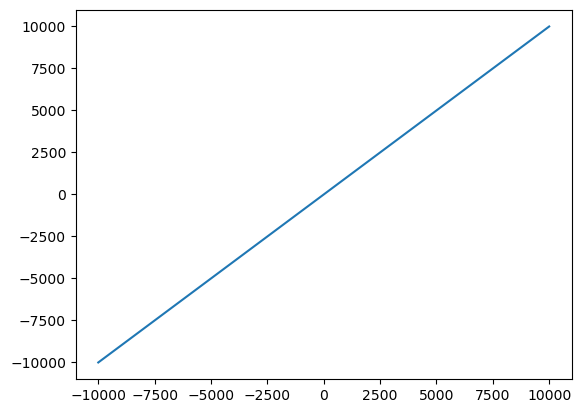

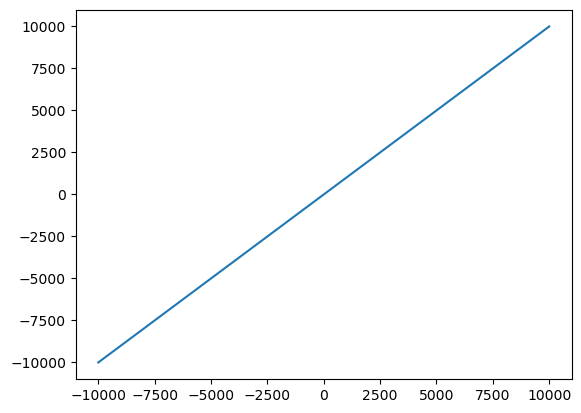

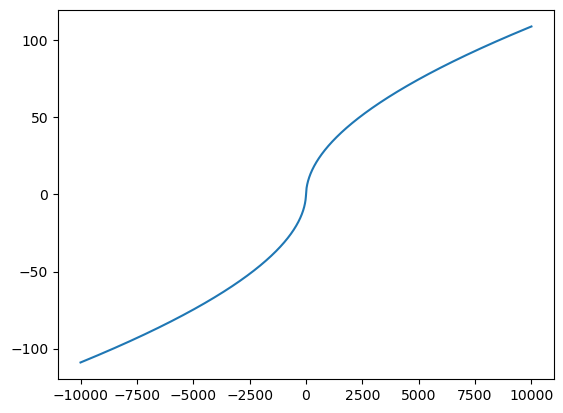

In [10]:
class RewardTran(nn.Module):    
    def __init__(self, support=300, eps=0.001):
        super(RewardTran, self).__init__()
        self.support = support
        self.eps = eps
        self.dec = torch.arange(-support, support + 1, 1)
        self.encoded_n = 2 * self.support + 1

    def forward(self, x):
        """encode the unencoded scalar reward or values to encoded scalar and encoded vector according to MuZero"""
        with torch.no_grad():
            sup, eps = self.support, self.eps
            enc_s = torch.sign(x)*(torch.sqrt(torch.abs(x)+1)-1)+eps*x
            enc_s = torch.clamp(enc_s, -sup, +sup)
            enc_v = torch.zeros(enc_s.shape+(2*sup+1,), dtype=torch.float32, device=enc_s.device)        
            enc_s_floor = torch.floor(enc_s)
            enc_v_reminder = enc_s - enc_s_floor
            enc_s_floor = enc_s_floor.long().unsqueeze(-1)
            enc_v.scatter_(-1, torch.clamp_max(sup+enc_s_floor+1, 2*sup) , enc_v_reminder.unsqueeze(-1))
            enc_v.scatter_(-1, sup+enc_s_floor, 1-enc_v_reminder.unsqueeze(-1))        
            return enc_s, enc_v

    def decode(self, x):
        """dncode the encoded vector to encoded scalar and unencoded scalar according to MuZero"""    
        with torch.no_grad():  
            sup, eps = 300, 0.001     
            dec = torch.arange(-sup, sup+1, 1)
            enc_s = torch.sum(dec*x, dim=-1)   
            dec_s = torch.sign(enc_s)*(torch.square((torch.sqrt(1+4*eps*(torch.abs(enc_s)+1+eps))-1)/(2*eps)) - 1) 
            return enc_s, dec_s

def reward_enc(x, sup=300, eps=0.0001):
    enc_s = torch.sign(x)*(torch.sqrt(torch.abs(x)+1)-1)+eps*x
    enc_s = torch.clamp(enc_s, -sup, +sup)
    return enc_s

def reward_dec(x, sup=300, eps=0.0001):
    return torch.sign(x)*(torch.square((torch.sqrt(1+4*eps*(torch.abs(x)+1+eps))-1)/(2*eps)) - 1)


rewardTran = RewardTran()
x = np.arange(-10000, 10000, 1)
x = torch.tensor(x)
enc_s, y = rewardTran(x)
enc_s_, x_ = rewardTran.decode(y)
plt.figure(0)
plt.plot(x, reward_dec(reward_enc(x)))
plt.figure(1)
plt.plot(x, x_)
plt.figure(2)
plt.plot(x, enc_s)

actor network size:  1937916
model network size:  536630


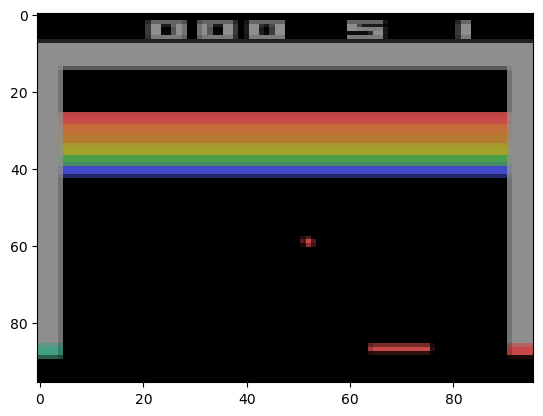

In [11]:
import thinker.env

env_n = 1
flags = util.parse([])
flags.rec_t = 5
flags.env = "BreakoutNoFrameskip-v4"
flags.actor_see_p = 1
flags.actor_drc = True
flags.model_type_nn = 2

env = Environment(flags, env_n=env_n)
model_net = ModelNet(env.gym_env_out_shape, env.num_actions, flags)
model_net.train(False)
env_out = env.initial(model_net)
actor_net = ActorNet(env.model_out_shape, env.gym_env_out_shape, env.num_actions, flags)

nc = actor_net
print("actor network size: ", sum(p.numel() for p in nc.parameters()))
nc = model_net
print("model network size: ", sum(p.numel() for p in nc.parameters()))

gplot(env_out.gym_env_out[0,0,:3])

In [656]:
for n in range(100000):
    im_actions = np.random.randint(low=0, high=4, size=flags.rec_t-1)
    #print(im_actions)
    for i in range(flags.rec_t - 1):
        env_out, _ = env.step(torch.tensor([[[0, im_actions[i], np.random.randint(low=0, high=2)] for k in range(env_n)]], dtype=torch.long), model_net)
        #print(env_out.cur_t)    
        if i == 0: 
            out_1 = env_out.gym_env_out.clone()
            #gplot(env_out.gym_env_out[0,0,-3:])

    env_out, _ = env.step(torch.tensor([[[im_actions[0], im_actions[1], 0] for k in range(env_n)]], dtype=torch.long), model_net)    
    out_2 = env_out.gym_env_out.clone()
    #gplot(env_out.gym_env_out[0,0,-3:])
    diff = torch.sum(torch.abs(out_1[0,0,:] - out_2[0,0,:]))
    if not env_out.done[0,0]: assert diff == 0, "diff %.2f " % diff
    if n % 100 == 0: print(n)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200


KeyboardInterrupt: 

TypeError: Invalid shape (3, 96, 96) for image data

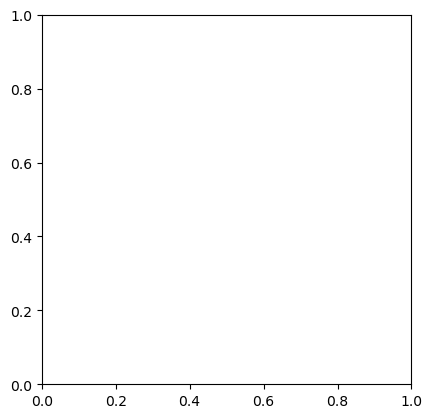

In [39]:
import thinker.env

env = gym.make("BreakoutNoFrameskip-v4")
env = thinker.env.PreWrap(env, "BreakoutNoFrameskip-v4")
#env = gym.make("BreakoutNoFrameskip-v4")

st = time.time()
obs = env.reset()         
state = env.clone_state()
plt.figure(0)
plt.imshow(obs[:3,:,:])
env.step(0)
for _ in range(200):
    obs, reward, done, info = env.step(3)
    if done: obs = env.reset()
print(time.time() - st)    
plt.figure(1)
plt.imshow(obs[0,:,:])

env.restore_state(state)
obs, reward, done, info = env.step(0)
plt.figure(2)
plt.imshow(obs[0,:,:])


In [ ]:
from PIL import Image
def save_img(x, name):
    x = env_out.gym_env_out[0,0]
    x = x.cpu()
    im = Image.fromarray(torch.swapaxes(torch.swapaxes(x,0,2),0,1).numpy())
    im.save(name)


In [ ]:
from thinker.env import Environment
from thinker.net import ModelNet

flags = util.parse([])
flags.actor_see_p = 0
flags.actor_drc = True
flags.rec_t = 5

env = Environment(flags)
model_net = ModelNet((3,80,80), 5, flags)
env_out, model_state = env.initial(model_net)
actor_net = ActorNet(env.model_out_shape, 5, flags)

nc = actor_net
print("actor network size: ", sum(p.numel() for p in nc.parameters()))
nc = model_net
print("model network size: ", sum(p.numel() for p in nc.parameters()))

a = torch.tensor([1,1,1]).long().unsqueeze(0).unsqueeze(0)
actor_state = actor_net.initial_state(1)

for n in range(5):
   env_out, model_state = env.step(a, model_net, model_state)
   actor_out, actor_state = actor_net(env_out, actor_state)

In [ ]:
a = torch.tensor([4,2,0]).long().unsqueeze(0).unsqueeze(0)
env_out, model_state = env.step(a, model_net, model_state)
cur_t = env_out.cur_t
x = env_out.gym_env_out[0]
plot_gym_env_out(x)
print(env_out.cur_t, env_out.see_mask, env.env.baseline_max_q)
device = torch.device("cuda")
actor_net.to(device)
actor_state = util.tuple_map(actor_state, lambda x: x.to(device))
env_out = util.tuple_map(env_out, lambda x: x.to(device))

out, actor_state = actor_net(env_out, actor_state)
print([x.dtype for x in out[0] if x is not None])


In [ ]:
k = 3
t = 4
n = 1
next_ind = np.array([3, np.nan, np.nan])

base_ind = 2 * n
base_ind_pri = t * base_ind

abs_flat_inds = np.array([6 + base_ind_pri, 5 + base_ind_pri])

# compute the correct index to update; if the indexes are across blocks,
# we have to carry the overflowing index to the next block

flat_inds = abs_flat_inds - base_ind_pri # get the relative index
mask = flat_inds > 0 
flat_inds = flat_inds[mask] 

flat_inds = flat_inds[:, np.newaxis] + np.arange(k) # flat_inds now stores uncarried indexes
flat_inds_block = flat_inds // (t * n) # block index of flat_inds
carry_mask = ~(flat_inds_block[:,[0]] == flat_inds_block).reshape(-1) 
# if first index block is not the same as the later index block, we need to carry it

flat_inds = flat_inds.reshape(-1)
flat_inds_block = flat_inds_block.reshape(-1)
carry_inds_block = next_ind[flat_inds_block[carry_mask]-1] - base_ind // n  # the correct index block

flat_inds = flat_inds.astype(float)
flat_inds[carry_mask] = flat_inds[carry_mask] + (-flat_inds_block[carry_mask] + carry_inds_block) * (t * n) 
mask = ~np.isnan(flat_inds)
flat_inds = flat_inds[mask].astype(int)
print(flat_inds_block)
print(carry_mask)
print(carry_inds_block)
print(flat_inds)

In [ ]:

flags = util.parse([])
flags.model_batch_size = 2
flags.model_buffer_n = 1000
flags.model_warm_up_n = 500
flags.model_batch_mode = False
flags.model_rnn = True
flags.model_unroll_length = 8
t = flags.model_unroll_length   
flags.model_k_step_return = 5
k = flags.model_k_step_return
flags.actor_parallel_n = 1
n = flags.actor_parallel_n  

flags.model_batch_mode = True

P = namedtuple("P", ["x","y"])
model_buffer = ModelBuffer(flags)

c = 0
for c in range(100):
    data = P(torch.full((t+k, n, 1),c), torch.full((t+k, n, 1),c+0.1))    
    state = (torch.full((n, 3),c+0.2), torch.full((n, 3),c+0.3))
    model_buffer.write(data, state, np.random.randint(10))

print(model_buffer.next_inds)
data, data_state, weights, abs_flat_inds, inds = model_buffer.read(1)
print(data.x[:, :, -1], data_state)

state = tuple(torch.zeros_like(x) for x in data_state)
priorities = torch.zeros(len(abs_flat_inds))

model_buffer.update_priority(abs_flat_inds, priorities, state)



In [ ]:
from thinker.env import Environment
from thinker.net import ModelNet

flags = util.parse([])
flags.model_rnn = True

model_net_1 = ModelNet((3,80,80), 5, flags)
nc = model_net_1
print("network size: ", sum(p.numel() for p in nc.parameters()))

flags.model_rnn = False
model_net_2 = ModelNet((3,80,80), 5, flags)
nc = model_net_2
print("network size: ", sum(p.numel() for p in nc.parameters()))

In [ ]:
tran = {"conv1":  "output_rvpi.conv1",
        "conv2":  "output_rvpi.conv2",
        "policy": "output_rvpi.fc_logits",
        "baseline": "output_rvpi.fc_v",
        "r": "output_rvpi.fc_r",
        "frame_conv.0":  "output_rvpi.conv1",
        "frame_conv.2":  "output_rvpi.conv2",}

state_dict = {}
for k in model_net_1.state_dict().keys():
    #print(k)
    if k not in model_net_2.state_dict().keys():
        for p, q in tran.items():
            if k[:len(p)+1] == p+".":
                out = q + k[len(p):]
                break
    else:
        out = k
    state_dict[k] = model_net_2.state_dict()[out]

model_net_1.load_state_dict(state_dict)
model_net_1.train(False)
model_net_2.train(False)

x = torch.rand(4, 3, 80, 80) * 2555
actions = torch.zeros(1, 4, dtype=torch.long)
done = torch.zeros(1, 4, dtype=torch.bool)

state = model_net_1.init_state(4)
vs, logits, states = model_net_1(x=x.unsqueeze(0), actions=actions, done=done, state=state)
print(logits)

rs, vs, logits, encodeds = model_net_2(x=x, actions=actions)
print(logits)

In [ ]:
from collections import namedtuple
import sys

import time
import numpy as np
import argparse
import ray
import torch

from thinker.self_play import SelfPlayWorker
from thinker.learn_actor import ActorLearner
from thinker.buffer import *
import thinker.util as util
from thinker.net import *


flags = util.parse()
obs_shape=(3,80,80)
num_actions = 5
flags.model_rnn = True

cnet = ModelNet(obs_shape, num_actions, flags, rnn=True)
x = torch.rand(10, 16, 3, 80, 80)
actions = torch.zeros(10, 16).long()
done = torch.zeros(10, 16).bool()
state = cnet.core.init_state(16)

vs, logits, state = cnet.forward(x, actions, done, state, one_hot=False)
vs, logits, state = cnet.forward(x, actions, done, state, one_hot=False)
print(vs, logits)

sys.exit()

parser = define_parser()
flags = parser.parse_args([])

self_play_worker = SelfPlayWorker(None, None, 1, flags)
self_play_worker.gen_data()


sys.exit()


flags = util.parse()
flags.model_batch_size = 2
flags.model_unroll_length = 8
flags.model_k_step_return = 5
flags.actor_parallel_n = 4
flags.model_buffer_n = 1000
flags.model_warm_up_n = 500
flags.model_batch_mode = False

t = flags.model_unroll_length   
k = flags.model_k_step_return
n = flags.actor_parallel_n  

P = namedtuple("P", ["x","y"])
model_buffer = ModelBuffer(flags)

c = 0
for c in range(100):
    data = P(torch.full((t+k, n, 1),2*c), torch.full((t+k, n, 1),2*c+1))    
    model_buffer.write(data)
    r = model_buffer.read(1.)    
    if r is not None:
        data, weights, abs_flat_inds, ps_step = r
        #print(data.x[:,:,0]) 
        #model_buffer.update_priority(abs_flat_inds, np.zeros(flags.model_batch_size))

print("1 read", data.x[:,:,0])
model_buffer.update_priority(abs_flat_inds, np.full(flags.model_batch_size, 1000000))
data, weights, abs_flat_inds, ps_step = model_buffer.read(1.)   
print("2 read", data.x[:,:,0])

sys.exit()

parser = define_parser()
flags = parser.parse_args([])
env = Environment(flags)
actor_net = ActorNet(obs_shape=env.model_out_shape, num_actions=env.num_actions, flags=flags)
model_net = ModelNet(obs_shape=env.gym_env_out_shape, num_actions=env.num_actions, flags=flags)
model_net.train(False)

out = env.initial(model_net)
print(out)
a = torch.tensor([1,0,1]).long()
a = a.unsqueeze(0).unsqueeze(0)

core_state = actor_net.initial_state(1)
out = env.step(a, model_net)
print(out)
print(actor_net(out, core_state))